In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split

import numpy as np
from matplotlib import pyplot as plt
from torchsummary import summary

Fix random seed

In [2]:
import random
# Set the seed for Python's built-in random module
random_seed = 42
random.seed(random_seed)

# Set the seed for NumPy
np.random.seed(random_seed)

# Set the seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Loading Dataset

We can load MNIST from Pytroch directly

In [3]:
from torchvision.datasets import MNIST

### Data Preprocessing

For better performance, we will standardize the input tensor (or images) using predetermined mean and standard deviation values (mean=0.1307, sd=0.3081)


Subsequently, we'll follow the usal procedure of splitting the dataset into training, validation, and testing sets.

In [4]:
batch_size_train = 64
batch_size_test = 1000

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

train_loader = torch.utils.data.DataLoader(
    MNIST('/files/', train=True, download=True,
                             transform = transform),
  batch_size=batch_size_train, shuffle=True)


test_loader = torch.utils.data.DataLoader(
    MNIST('/files/', train=False, download=True,
                             transform = transform),
  batch_size=batch_size_test, shuffle=True)

The shape of inputs for tranining would be batch size = 64   
channel = 1   
height,width = 28, 28

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

Let's display some picture for the dataset

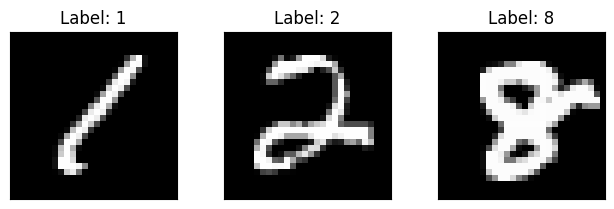

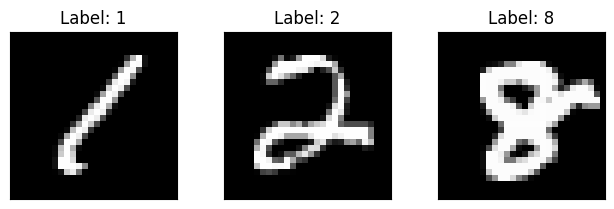

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(3):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Now we are ready to build out network!  
For simplicity, we will build a simple CNN network to compare different optimizer

### Create a CNN Model

In [7]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super(Simple_CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.fc = nn.Linear(64 * 2 * 2, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))

        x = self.flatten(x)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)


Print summary table of the model

In [8]:
model = Simple_CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         MaxPool2d-2             [-1, 32, 9, 9]               0
            Conv2d-3             [-1, 64, 5, 5]          51,264
         MaxPool2d-4             [-1, 64, 2, 2]               0
           Flatten-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 54,666
Trainable params: 54,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.21
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


### Fitting model

In [9]:
def fit(model, optimizer, train_loader):
    # Use GPU to train
    model = model.to(device)

    EPOCHS = 20
    model.train()
    loss_values = []

    for epoch in range(EPOCHS):
        correct = 0
        running_loss = 0.0
        total_samples = 0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)

            loss = F.nll_loss(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_values.append(epoch_loss)

        print('[Epoch %d] Loss: %.3f' % (epoch + 1, epoch_loss))

    return loss_values


First, we will fit the Adam Optimizer with learning rate of 5e-4 and beta as (0.9,0.999) as the original paper suggests

In [10]:
cnn_adam = Simple_CNN().to(device)
Adam = torch.optim.Adam(cnn_adam.parameters(), lr=5e-4, betas=(0.9, 0.999))
Adam_model = fit(cnn_adam, Adam, train_loader)

[Epoch 1] Loss: 0.217
[Epoch 2] Loss: 0.061
[Epoch 3] Loss: 0.044
[Epoch 4] Loss: 0.034
[Epoch 5] Loss: 0.028
[Epoch 6] Loss: 0.023
[Epoch 7] Loss: 0.018
[Epoch 8] Loss: 0.016
[Epoch 9] Loss: 0.014
[Epoch 10] Loss: 0.011
[Epoch 11] Loss: 0.010
[Epoch 12] Loss: 0.008
[Epoch 13] Loss: 0.007
[Epoch 14] Loss: 0.007
[Epoch 15] Loss: 0.007
[Epoch 16] Loss: 0.005
[Epoch 17] Loss: 0.005
[Epoch 18] Loss: 0.004
[Epoch 19] Loss: 0.005
[Epoch 20] Loss: 0.002


We also train with a naive SGD Optimizer with learing rate of 5e-4

In [11]:
cnn_sgd = Simple_CNN().to(device)
SGD_optimizer = torch.optim.SGD(cnn_sgd.parameters(), lr=5e-4)
SGD_model = fit(cnn_sgd, SGD_optimizer, train_loader)

[Epoch 1] Loss: 2.033
[Epoch 2] Loss: 1.323
[Epoch 3] Loss: 0.742
[Epoch 4] Loss: 0.510
[Epoch 5] Loss: 0.407
[Epoch 6] Loss: 0.348
[Epoch 7] Loss: 0.309
[Epoch 8] Loss: 0.280
[Epoch 9] Loss: 0.258
[Epoch 10] Loss: 0.239
[Epoch 11] Loss: 0.224
[Epoch 12] Loss: 0.211
[Epoch 13] Loss: 0.200
[Epoch 14] Loss: 0.191
[Epoch 15] Loss: 0.182
[Epoch 16] Loss: 0.174
[Epoch 17] Loss: 0.167
[Epoch 18] Loss: 0.161
[Epoch 19] Loss: 0.155
[Epoch 20] Loss: 0.150


Adagrad with learning rate of 5e-4

In [12]:
cnn_Adagrad = Simple_CNN().to(device)
Adagrad = torch.optim.Adagrad(cnn_Adagrad.parameters(), lr=5e-4)
Adagrad_model = fit(cnn_Adagrad, Adagrad, train_loader)

[Epoch 1] Loss: 0.793
[Epoch 2] Loss: 0.358
[Epoch 3] Loss: 0.279
[Epoch 4] Loss: 0.240
[Epoch 5] Loss: 0.216
[Epoch 6] Loss: 0.199
[Epoch 7] Loss: 0.186
[Epoch 8] Loss: 0.176
[Epoch 9] Loss: 0.167
[Epoch 10] Loss: 0.160
[Epoch 11] Loss: 0.154
[Epoch 12] Loss: 0.148
[Epoch 13] Loss: 0.144
[Epoch 14] Loss: 0.139
[Epoch 15] Loss: 0.135
[Epoch 16] Loss: 0.132
[Epoch 17] Loss: 0.129
[Epoch 18] Loss: 0.126
[Epoch 19] Loss: 0.123
[Epoch 20] Loss: 0.121


RMSprop with learning rate of 5e-4

In [13]:
cnn_RMSprop = Simple_CNN().to(device)
RMSprop = torch.optim.RMSprop(cnn_RMSprop.parameters(), lr=5e-4)
RMSprop_model = fit(cnn_RMSprop, RMSprop, train_loader)

[Epoch 1] Loss: 0.209
[Epoch 2] Loss: 0.070
[Epoch 3] Loss: 0.051
[Epoch 4] Loss: 0.040
[Epoch 5] Loss: 0.033
[Epoch 6] Loss: 0.028
[Epoch 7] Loss: 0.024
[Epoch 8] Loss: 0.021
[Epoch 9] Loss: 0.018
[Epoch 10] Loss: 0.016
[Epoch 11] Loss: 0.013
[Epoch 12] Loss: 0.011
[Epoch 13] Loss: 0.010
[Epoch 14] Loss: 0.009
[Epoch 15] Loss: 0.008
[Epoch 16] Loss: 0.007
[Epoch 17] Loss: 0.006
[Epoch 18] Loss: 0.006
[Epoch 19] Loss: 0.004
[Epoch 20] Loss: 0.005


L-BFGS with learning rate of 5e-4, max_iteration of 1 and history size = 20.


Although L-BFGS holds theoretical superiority by leveraging second-order derivatives, the practical limitation of computational resources constrains the increase useage of both the maximum iteration count and history size to attain its optimal efficacy. It is noteworthy that the study conducted by Le et al., titled "On Optimization Methods for Deep Learning," attests to the achievement of state-of-the-art outcomes in convolutional neural networks through the application of L-BFGS.

In [14]:
cnn_LBFGS = Simple_CNN()
cnn_LBFGS.to(device)
LBFGS = torch.optim.LBFGS(cnn_LBFGS.parameters(),lr=5e-4,max_iter=1,history_size=20,
                          line_search_fn='strong_wolfe')

epochs = 20
LBFGS_loss = []

for epoch in range(epochs):
    running_loss = 0.0

    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      def closure():
        # Zero gradients
        LBFGS.zero_grad()
        y_pred = cnn_LBFGS(X_batch)
        loss = F.nll_loss(y_pred, y_batch)
        loss.backward()
        return loss

      LBFGS.step(closure)
      loss = closure()
      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    LBFGS_loss.append(epoch_loss)

    print('[Epoch %d] Loss: %.3f' % (epoch + 1, epoch_loss))



[Epoch 1] Loss: 0.268
[Epoch 2] Loss: 0.155
[Epoch 3] Loss: 0.134
[Epoch 4] Loss: 0.117
[Epoch 5] Loss: 0.105
[Epoch 6] Loss: 0.097
[Epoch 7] Loss: 0.091
[Epoch 8] Loss: 0.084
[Epoch 9] Loss: 0.079
[Epoch 10] Loss: 0.075
[Epoch 11] Loss: 0.069
[Epoch 12] Loss: 0.066
[Epoch 13] Loss: 0.062
[Epoch 14] Loss: 0.061
[Epoch 15] Loss: 0.058
[Epoch 16] Loss: 0.056
[Epoch 17] Loss: 0.052
[Epoch 18] Loss: 0.051
[Epoch 19] Loss: 0.048
[Epoch 20] Loss: 0.048


Plot Training Loss for comparision

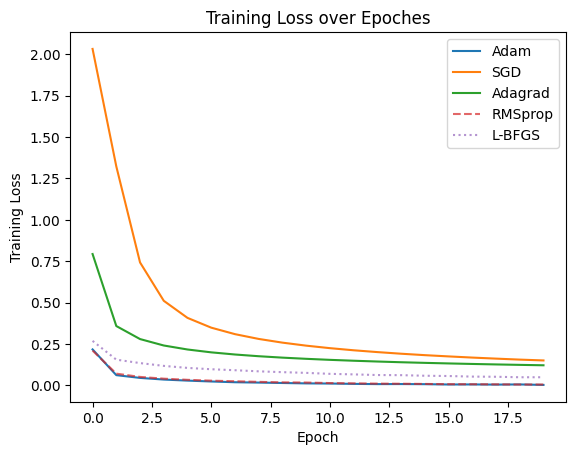

In [15]:
plt.plot(Adam_model, label='Adam')
plt.plot(SGD_model,label='SGD')
plt.plot(Adagrad_model,label='Adagrad')
plt.plot(RMSprop_model,linestyle='--',label='RMSprop',alpha=0.7)
plt.plot(LBFGS_loss,linestyle=':',label='L-BFGS',alpha=0.7)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epoches')
plt.legend()
plt.show()

Evaluate these methods on test sets to compare their accuracy

In [16]:
def evaluate(model):
  model.eval()
  correct = 0

  with torch.no_grad():
    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
        test_imgs = test_imgs.float().to(device)
        output = model(test_imgs)
        #calculate accuracy
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()

    accuracy = correct / (len(test_loader.dataset))
    print("Accuracy: {:.3f}%".format(accuracy * 100))


In [17]:
evaluate(cnn_adam)

Accuracy: 99.230%


In [18]:
evaluate(cnn_sgd)

Accuracy: 96.090%


In [19]:
evaluate(cnn_RMSprop)

Accuracy: 98.980%


In [20]:
evaluate(cnn_Adagrad)

Accuracy: 96.850%


In [21]:
evaluate(cnn_LBFGS)

Accuracy: 98.600%


As shown above, Adam acheive the best accuracy, and RMSprop and L-BFGS also provide competitive results.